In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf #needed for models in this script
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
pd.set_option('html', True) #see the dataframe in a more user friendly manner
%matplotlib inline

## Overview of Time Series Analysis

One approach to this analysis asserts that all time series can be broken into three components so that Y=m+s+e, where "Y" is the series, "m" is the trend, "s" is the seasonal component and "e" is random noise. The trend component can be thought of as longer-term change and is often calculated my taking a moving average over a certain time span.The seasonal component is short-term periodic fluctuations that are measured by averaging detrended observations (Y-m) that are separated by a constant number of observations. For example, you can think of the price of gasoline as having a long-term trend (say declining) which experiences regular increases every twelve months when people start to take vacations.

Another approach is known as exponential smoothing. The idea behind this method is to forecast predictions based on a weighted average of the most recent observations. The weighting is typically a geometrically declining series that sums to 1, so the most recent observations are given the most weight. The result is a smoothed series that reflects the pattern of the most recent observations. New observations are then seen as a function of this smooth series and the most recent observation. The most common application, the Holt-Winters methods, also incorporates trend terms and a seasonal component.

Two good series on Time Series Analysis; i) https://www.youtube.com/watch?v=F3Kjdz4K7vE by Jason Delaney (series of videos and ii) https://www.youtube.com/watch?v=0unf-C-pBYE by Wes McKinney (3.5 hour video).

## ARIMA analysis with Loan Data

A more involved approach to time-series analysis is the ARIMA method. The acronym stands for "Auto-Regressive Integrated Moving Average", the main components of the model. The general idea behind this model is that a series can be expressed as a function of its most recent observations ("auto-regressive" indicates a regression of an observation on itself, or more specifically, running a regression on an observation using previous observations as explanatory variables) as well as a trend component of the forecast errors (moving average).

ARIMA models assume that the time-series is stationary, which in this context, means that the mean, variance and autocorrelation does not change over time. In practice this means that a differenced series (the result of subtracting a set of observations in a series with a previous observation of a fixed time lag) is often used to model an ARIMA process. Adding back the difference to get a model for the original series is considered "integrating."

#### Goal: Using Lending Club Statistics, create a monthly time series of the loan counts by the issue date (issue_d).

In [5]:
loanData = pd.read_csv('LoanStats3b.csv', header=1, low_memory=False)
# header=1 tells the file to be read in with the column headers beginning in the 2nd row (0 is the first row)
# low_memory=False beacuse there are columns in this dataset with mixed datatypes so setting this parameter will tell pandas
# to ignore datatypes; we will set them manually if need be. 
loanData.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,10149526,12001069,27600,27600,27600,60 months,19.97%,730.78,D,D5,...,0,0,0,Sep-2015,730.78,Nov-2015,Sep-2015,0,7,1
1,10224583,12086734,11100,11100,11100,36 months,14.98%,384.68,C,C3,...,0,0,0,Sep-2015,384.68,Nov-2015,Sep-2015,0,16,1


In [6]:
# Convert issue_d datatype (current = object) to datetime:
loanData['issue_d_format'] = pd.to_datetime(loanData['issue_d']) 

# Set this new column to the index:
loanData = loanData.set_index('issue_d_format') 

# Confirm:
loanData.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
issue_d_format,,,,,,,,,,,,,,,,,,,,,
2013-12-26,10149526,12001069,27600,27600,27600,60 months,19.97%,730.78,D,D5,...,0,0,0,Sep-2015,730.78,Nov-2015,Sep-2015,0,7,1
2013-12-26,10224583,12086734,11100,11100,11100,36 months,14.98%,384.68,C,C3,...,0,0,0,Sep-2015,384.68,Nov-2015,Sep-2015,0,16,1


In [8]:
# Calculate monthly totals in new dataframe:

year_month_summary = loanData.groupby(lambda x : x.year * 100 + x.month).count()
# This new dataframe is grouped by the index; taking the year, multiplying by 100 and then adding the month. This creates a 
# unique number for each month. 

year_month_summary.head()
#each month should have matching counts for most variables. The results here indicate a rapidly rising application count. 

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
201201,2602,2602,2602,2602,2602,2602,2602,2602,2602,2602,...,2602,2602,2602,2597,2602,191,2602,2602,0,2602
201202,2560,2560,2560,2560,2560,2560,2560,2560,2560,2560,...,2560,2560,2560,2553,2560,182,2560,2560,0,2560
201203,2914,2914,2914,2914,2914,2914,2914,2914,2914,2914,...,2914,2914,2914,2909,2914,201,2914,2914,0,2914
201204,3230,3230,3230,3230,3230,3230,3230,3230,3230,3230,...,3230,3230,3230,3227,3230,208,3230,3230,0,3230
201205,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,...,3400,3400,3400,3395,3400,265,3400,3400,0,3400


In [9]:
# Isolate issue_d column:
loan_count_summary = year_month_summary.loc[:,('issue_d')]
loan_count_summary

201201     2602
201202     2560
201203     2914
201204     3230
201205     3400
201206     3817
201207     4627
201208     5419
201209     6087
201210     6263
201211     6382
201212     6066
201301     6872
201302     7561
201303     8273
201304     9419
201305    10350
201306    10899
201307    11910
201308    12674
201309    12987
201310    14115
201311    14676
201312    15020
Name: issue_d, dtype: int64

## Plot Autocorrelation in Loan Data

The difficulty with ARIMA models is deciding which terms to include in the various components of the model. In modern packages this is often decided by examining the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. The ACF plots the correlation between observations and the observations from a previous fixed time period or lag. The PACF plots the correlation of an observation and the observation with a given lag, but with the linear relationships of all intervening observations controlled for.

A pattern of consistent significant autocorrelation across all lags, with little indication of decay as the lag increases, usually indicates a non-stationary series that needs to be differenced for the analysis to continue.

![](files/ac1.jpg)

Similarly, significant spikes in autocorrelation that occur at regular lag intervals suggest that there is a seasonality that needs to be addressed by differencing the series at intervals equal to the lag.

![](files/ac2.jpg)

A pattern of quickly decaying autocorrelations but with persistent partial autocorrelations implies that the model is best served by an MA terms to match the lags of significant autocorrelations.

Analogously, persistent autocorrelation with quickly decaying partial autocorrelations point towards adding AR terms to match the significant partial autocorrelations.

![](files/ac3.jpg)

ARIMA modeling can be tricky and face common pitfalls like overdifferencing and non-convergence. Unlike some more formal techniques, the final models can be a process driven by nuance and judgement.

Good Notes on ARIMA modelling: http://people.duke.edu/~rnau/411arim.htm

## Challenge

Plot the loan data (loan_count_summary in from the previous assignment). Is the series stationary? If not, what would you do to transform it into a stationary series?

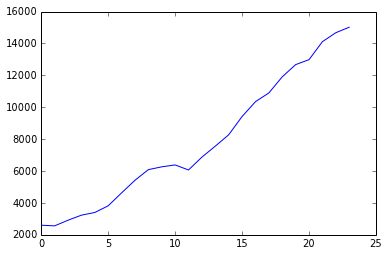

In [10]:
# plotted data:
plt.plot(loan_count_summary)

This is definitely not stationary as it's continually increasing with time.

Non-stationary data, as a rule, are unpredictable and cannot be modeled or forecasted. The results obtained by using non-stationary time series may be spurious in that they may indicate a relationship between two variables where one does not exist. In order to receive consistent, reliable results, the non-stationary data needs to be transformed into stationary data. In contrast to the non-stationary process that has a variable variance and a mean that does not remain near, or returns to a long-run mean over time, the stationary process reverts around a constant long-term mean and has a constant variance independent of time.

In [21]:
# To transform the data - Take differences but only absoulte values; we don't want to see negative values as they can cancel out
# positive values. 
loan_count_summary_diff = abs(loan_count_summary.diff())
loan_count_summary_diff = loan_count_summary_diff.fillna(0) #get rid of the NaN value for the first month

loan_count_summary_diff

201201       0
201202      42
201203     354
201204     316
201205     170
201206     417
201207     810
201208     792
201209     668
201210     176
201211     119
201212     316
201301     806
201302     689
201303     712
201304    1146
201305     931
201306     549
201307    1011
201308     764
201309     313
201310    1128
201311     561
201312     344
Name: issue_d, dtype: float64

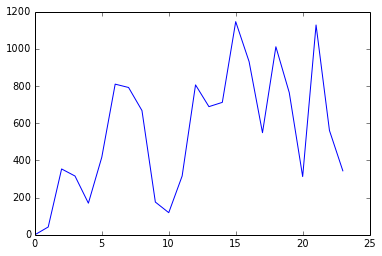

In [22]:
# Plot the differences:
plt.plot(loan_count_summary_diff)

This is more stationary than we had before; but still has a lot of variation. 

In [ ]:
************* Ask - how do we smooth this data more? ***************

Plot out the ACF (statsmodels.api.graphics.tsa.plot_acf()) and PACF (statsmodels.api.graphics.tsa.plot_pacf()) of the series (or the transformed series). Are there any autocorrelated structures in the series? How would you have a model address these structures?

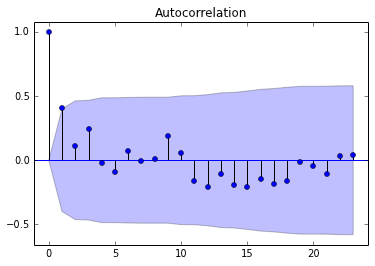

In [29]:
# ACF Plot on Transformed Data:
sm.graphics.tsa.plot_acf(loan_count_summary_diff); # autocorrelation, NOTE: ';' to supress output in ipython so this shows
# only one graph

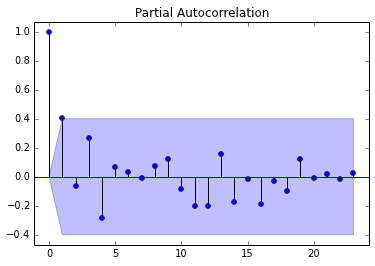

In [30]:
sm.graphics.tsa.plot_pacf(loan_count_summary_diff); # partial autocorrelation

I don't see any autocorrelated structures in this dataset. 

In [ ]:
****** Need to understand these graphs better ****** 